# Decision Trees using Scikit-Learn

**AUTHOR**: Alma Qasreena

This Jupyter Notebook provide the example of simple Machine Learning classification using Scikit-Learn.

We will be using the following modelling techniques:

* Deep Neural Network (DNN)
* Decision Tree
* AdaBoost
* Gradient Boosting

AdaBoost and Gradient Boosting is one of the most popular boosting algorithm method for Decision Tree that is shown in this notebook

We begin by importing a few essential libraries and then load the data sets that will be use

In [61]:
%matplotlib inline

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
# Use flag to make it easier to compare the line produced by DNN, Decision Tree, AdaBoost, Gradient Boosting
PLOT    = True
DO_DNN  = True
DO_DT   = True
DO_AB   = True
DO_GB   = True
VERBOSE = True

The data set is available in two formats: ROOT and HDF5. The former is predominantly used by the high energy physics community, while the latter is more familiar to data scientists and other users.

In this notebook, we will be using ROOT files.The uproot package can be used to read a .root file to Python without having to necessarily install the whole ROOT software.

In [64]:
# load the ROOT files

filePath   =  '../files/JetNtuple_RunIISummer16_13TeV_MC_1_skimmed.root'
tree       =   uproot.open(filePath)['jetTree']

In [66]:
# Create and fill a dataframe
df             = pd.DataFrame()
remaining_vars = []

# Classification of Quark or Gluon Jets

The main objective in this example is to train a simple machine learning so that it will be able to classify which jets originate from gluons or quark(up,down and strange).This is an important task, since on the observable macroscopic level the two types of jets look very similar, but from a physical point of view the difference between them is significant.

In [67]:
# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
for key in tree.keys():

    if str(type(tree[key].array()[0])) != "<class 'awkward.highlevel.Array'>":
        df[key] = np.array(tree[key].array())
    else:
        remaining_vars.append(key)
    pass

df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()


if VERBOSE: print(df)
    
if VERBOSE:      
    print("Remaining variables not accounted for:")
    print(remaining_vars)

       index  QG_axis2  QG_mult    QG_ptD     alpha  dEtaJetsLO  dPhiJetsLO  \
0          0  0.009762       16  0.489665  0.592001   -0.470722    2.585887   
1          3  0.005259       21  0.464368  0.477828    0.626809    2.961258   
2         12  0.070929       25  0.277553  0.466182   -1.369172    2.748459   
3         13  0.114792       16  0.321609  0.466182   -1.369172    2.748459   
4         15  0.012830       30  0.382597  0.146675   -1.041257   -3.130780   
...      ...       ...      ...       ...       ...         ...         ...   
13907  28595  0.017929       36  0.299219  0.058687   -1.072905   -3.101364   
13908  28596  0.006848       41  0.586562  0.349773   -1.661101   -3.118130   
13909  28597  0.020654       42  0.301372  0.349773   -1.661101   -3.118130   
13910  28600  0.009762       30  0.336677  0.606247    0.188552   -3.008861   
13911  28610  0.022920       52  0.275605  0.319895   -1.849314   -2.716663   

       eventJetMult   eventWeight  hadronFlav  ... 

From left to right these variables are the **jet multiplicity (QG_mult)**, the **jet momentum distribution variable (QG_ptD)** and the **jet minor axis (QG_axis2)**.

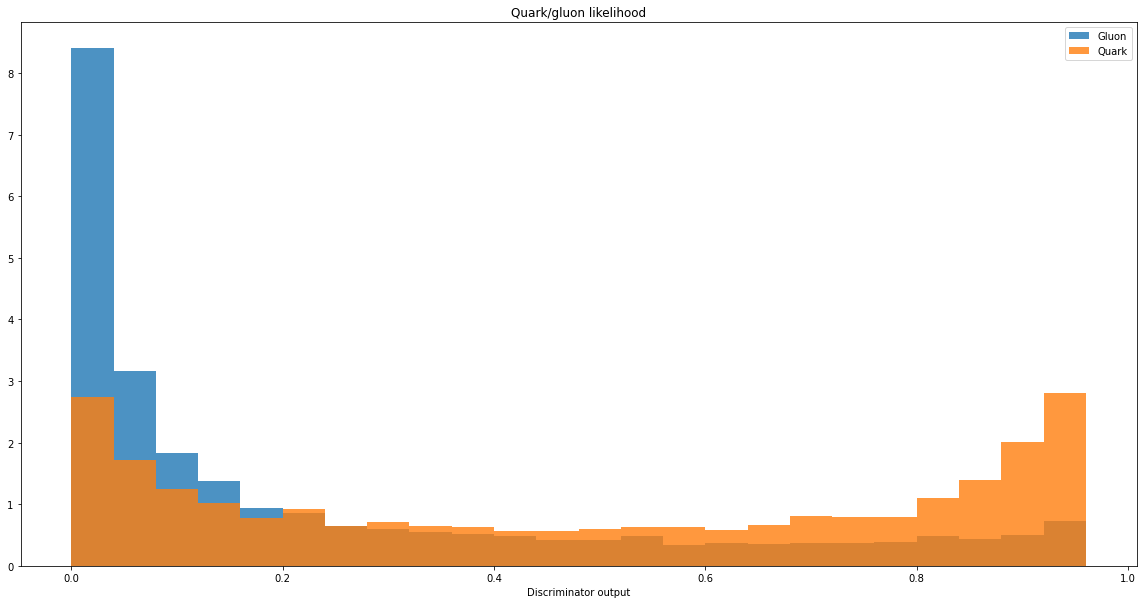

In [68]:
if PLOT:
    #
    #Plotting Variables
    #

    hist_columns = ['QG_mult','QG_ptD','QG_axis2']
    binnings = [np.arange(0,70,2), np.arange(0.0,1.0,0.04), np.arange(0.0,0.2,0.01)]
    ind = 0
    fig, axes = plt.subplots(1, 3, figsize=(20,10))

    for column in hist_columns:
        axes[ind].hist( df[df.isPhysG==1][column], bins=binnings[ind], alpha=0.8, label='Gluon', density=1 )
        axes[ind].hist( df[df.isPhysUDS==1][column], bins=binnings[ind], alpha=0.8, label='Quark', density=1 )
        axes[ind].set_xlabel(column)
        axes[ind].legend()
        ind = ind+1

    plt.clf()

    binning = np.arange(0.0, 1.0, 0.04)
    plt.hist( df[df.isPhysG==1]['jetQGl'], bins=binning, alpha=0.8, label='Gluon', density=1 )
    plt.hist( df[df.isPhysUDS==1]['jetQGl'], bins=binning, alpha=0.8, label='Quark', density=1 )
    plt.legend()
    plt.xlabel('Discriminator output')
    plt.title('Quark/gluon likelihood');



In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

test_y = test.isPhysUDS

input_features = ['jetPt', 'jetEta', 'QG_mult', 'QG_ptD', 'QG_axis2']

if DO_DNN:

    train_y_dnn = train.isPhysUDS
    test_y_dnn = test.isPhysUDS

    train_x_dnn = train[input_features]
    test_x_dnn = test[input_features]

    train_x_dnn_mean = train_x_dnn.mean()
    train_x_dnn_std = train_x_dnn.std()

    train_x_dnn = (train_x_dnn - train_x_dnn_mean) / train_x_dnn_std
    test_x_dnn = (test_x_dnn - train_x_dnn_mean) / train_x_dnn_std

if DO_DT:

    train_y_dt = train.isPhysUDS
    test_y_dt = test.isPhysUDS

    train_x_dt = train[input_features]
    test_x_dt = test[input_features]

    train_x_dt_mean = train_x_dt.mean()
    train_x_dt_std = train_x_dt.std()

    train_x_dt = (train_x_dt - train_x_dt_mean) / train_x_dt_std
    test_x_dt = (test_x_dt - train_x_dt_mean) / train_x_dt_std

if DO_AB:

    train_y_ab = train.isPhysUDS
    test_y_ab = test.isPhysUDS

    train_x_ab = train[input_features]
    test_x_ab = test[input_features]

    train_x_ab_mean = train_x_ab.mean()
    train_x_ab_std = train_x_ab.std()

    train_x_ab = (train_x_ab - train_x_ab_mean) / train_x_ab_std
    test_x_ab = (test_x_ab - train_x_ab_mean) / train_x_ab_std


if DO_GB:

    train_y_gb = train.isPhysUDS
    test_y_gb = test.isPhysUDS

    train_x_gb = train[input_features]
    test_x_gb = test[input_features]

    train_x_gb_mean = train_x_gb.mean()
    train_x_gb_std = train_x_gb.std()

    train_x_gb = (train_x_gb - train_x_gb_mean) / train_x_gb_std
    test_x_gb = (test_x_gb - train_x_gb_mean) / train_x_gb_std


In [ ]:
if DO_DNN:

    #
    # Deep Neural Network (DNN)
    #
    import tensorflow as tf
    import keras.backend as K

    sess = tf.compat.v1.Session()
    tf.compat.v1.keras.backend.set_session(sess)

    from keras.models import Model, Sequential
    from keras.layers import Input, Dense, Dropout
    from sklearn.utils import class_weight

    # Define the DNN architecture
    model = Sequential()
    model.add(Dense(100, kernel_initializer='normal', activation='relu', input_dim=train_x_dnn.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

    # Weight the training samples so that there is equal weight on gluon and quark jets
    # even if there are different amount of them in the training set
    class_weights = class_weight.compute_class_weight(
                                                        class_weight  = 'balanced',
                                                        classes  = np.unique(train_y_dnn),
                                                        y =   train_y_dnn
                                                    )

    class_weights = dict(zip(np.unique(train_y_dnn), class_weights))

    # Train the model
    model.fit(train_x_dnn,
              train_y_dnn,
              epochs=20,
              batch_size=128,
              class_weight=class_weights,
              validation_split=0.2,
              shuffle=True,
              verbose=1);

    pred_y_dnn = model.predict(test_x_dnn)

In [ ]:
if PLOT and DO_DNN:

    plt.clf()
    binning = np.arange(0.0, 1.0, 0.04)
    plt.hist( pred_y_dnn[test_y_dnn==0], bins=binning, alpha=0.8, label="Gluons", density=1 )
    plt.hist( pred_y_dnn[test_y_dnn==1], bins=binning, alpha=0.8, label="Quarks", density=1 )
    plt.legend()
    plt.xlabel('DNN output value')
    plt.title('Simple DNN classifier');
    

In [ ]:
if DO_DT:

    from sklearn.tree import DecisionTreeClassifier

    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(train_x_dt, train_y_dt)

    pred_y_dt = clf.apply(test_x_dt)

if DO_AB:

    from sklearn.ensemble import AdaBoostClassifier 

    clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(train_x_ab, train_y_ab)

    pred_y_ab = clf.decision_function(test_x_ab)


if DO_GB:

    from sklearn.ensemble import GradientBoostingClassifier

    clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
    clf.fit(train_x_gb, train_y_gb)

    pred_y_gb = clf.decision_function(test_x_gb)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

if DO_DNN:
    fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(test_y_dnn, pred_y_dnn)
    roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

if DO_DT:
    fpr_dt, tpr_dt, thresholds_dt  = roc_curve(test_y_dt, pred_y_dt)
    roc_auc_dt = auc(fpr_dt, tpr_dt)

if DO_AB:
    fpr_ab, tpr_ab, thresholds_ab  = roc_curve(test_y_ab, pred_y_ab)
    roc_auc_ab = auc(fpr_ab, tpr_ab)

if DO_GB:
    fpr_gb, tpr_gb, thresholds_gb  = roc_curve(test_y_gb, pred_y_gb)
    roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_qgl, tpr_qgl, thresholds_qgl = roc_curve(test_y, test.jetQGl)
roc_auc_qgl = auc(fpr_qgl, tpr_qgl)


In [ ]:
if PLOT:

    plt.clf()
    plt.plot(fpr_qgl, tpr_qgl, 'r', label='Likelihood discriminator, AUC = %0.2f'% roc_auc_qgl)

    if DO_DNN: 
        plt.plot(fpr_dnn, tpr_dnn, 'b', label='DNN classifier, AUC = %0.2f'% roc_auc_dnn)
    if DO_DT : 
        plt.plot(fpr_dt , tpr_dt , 'y', label='DT classifier, AUC = %0.2f'% roc_auc_dt)
    if DO_AB : 
        plt.plot(fpr_ab , tpr_ab , 'g', label='AB classifier, AUC = %0.2f'% roc_auc_ab)
    if DO_GB : 
        plt.plot(fpr_gb , tpr_gb , 'c', label='GB classifier, AUC = %0.2f'% roc_auc_gb)
        
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc = 'lower right')
    plt.title("Receiver operating characteristic")
    plt.ylabel('Quark jet acceptance rate')
    plt.xlabel('Gluon jet acceptance rate');
